### Image Captioning 
- Converting Image to a text.
    - Works as visual Aid for blind people.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 8ADB-680F

 Directory of C:\Users\dell\Desktop\Machine Learning\Project Image Captioning

13-03-2021  19:44    <DIR>          .
13-03-2021  19:44    <DIR>          ..
11-03-2021  15:05    <DIR>          .ipynb_checkpoints
08-03-2021  04:31     1,112,971,163 archive.zip
08-03-2021  10:50    <DIR>          dataset
10-03-2021  15:55         2,311,419 descriptions_1.txt
10-03-2021  15:39        13,127,425 encoded_test_features.pkl
10-03-2021  15:39        53,631,791 encoded_train_features.pkl
08-03-2021  11:22             9,633 f1.GIF
08-03-2021  14:40             7,998 f2.GIF
08-03-2021  14:50            50,786 f3.GIF
08-03-2021  18:11             7,041 f4.GIF
08-03-2021  18:19            34,324 f5.GIF
08-03-2021  18:22            84,717 f6.png
08-03-2021  18:30           271,827 f7.png
08-03-2021  18:34           196,639 f8.png
13-03-2021  19:42         1,145,844 Image Captioning .ipynb
13-03-2021  19:44            44,652 model.png
08-03-

In [4]:
# read text captions

def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [5]:
captions = readTextFile('./dataset/captions.txt')

In [6]:
captions = captions.split('\n')[:-1]

In [7]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt watches kayakers .'

In [8]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]
    
    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)


In [9]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
import cv2

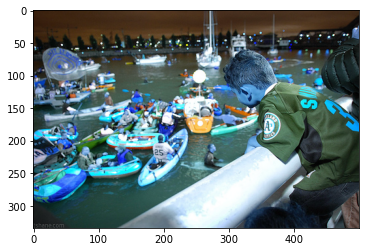

['A boy in a green shirt is looking down at many inflatable boats .',
 'A boy in a green shirt watches kayakers .',
 'A boy looks over a railing at the many boats and rafts below in the water .',
 'A young boy overlooking a crowd of inflatable boats .',
 'A young boy wearing a jersey looks down over a ledge at many boats in the water .']

In [11]:
path = './dataset/images/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']

### Data Cleaning
**HERE**
- Do not remove stopwords
- Do not stemming
- Remove numbers, punctuations

$X \rightarrow MODEL \rightarrow \textbf{Dense layer with soft max}\rightarrow vector[\textbf{probability distribution of each word}]$

In [12]:
import re

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [14]:
# clean all captions

In [15]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [17]:
# write the data to text file 
with open('./dataset/description.txt','w') as f:
    f.write(str(desc))


### Vocabulary
- It is a set of all possible unique words that model can predict.

In [18]:
import json

In [19]:
descriptions = None
with open('./dataset/description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)

In [20]:
#descriptions

In [21]:
print(type(descriptions))

<class 'dict'>


In [22]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [23]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8257


In [24]:
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'apple', 'hi', 'hello'}


In [25]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [26]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 357791


In [27]:
len(total_words), type(total_words)

(357791, list)

In [28]:
# filter words from vocab according to certain threshold frequency

In [29]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
# print(frq_cnt)

8257


In [30]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [31]:
#sorted_freq_cnt

In [32]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [33]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

### Train/Test Data

In [34]:
len(descriptions.keys()), len(descriptions.values())

(8091, 8091)

In [35]:
train_file_data = readTextFile('./dataset/train.txt')
test_file_data = readTextFile('./dataset/test.txt')

In [36]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [37]:
len(train), len(test)

(6500, 1591)

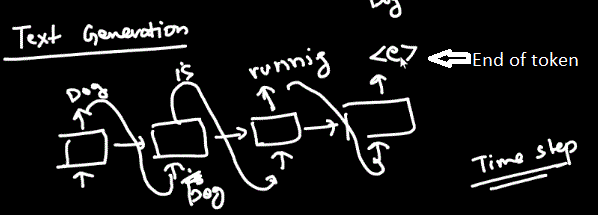
- This model will be able to **generate end of sentence token** only if we have the token in out training data.
- What we will do is that, when the caption is given we will add start and end token to it.
- $<start>$ DOG IS BARKING $<end>$

In [38]:
print(descriptions.get('1000268201_693b08cb0e.jpg'))

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [39]:
train[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [39]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [40]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images -> Features
- Text -> Features
<br>

### Step 1: Image Feature Extraction
   - Using ResNet50 to extract features which is already trained on imagenet.
   - Resnet50 is very deep model it has 50 layers with skip connection they dont have suffer from Vanishing Gradient. 
   - ResNe50 is not a sequential model it can skip connetions.

In [40]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [ ]:
img = preprocess_img('./dataset/images/'+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)  
    feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image('./dataset/images/'+"1000268201_693b08cb0e.jpg")

In [ ]:
type(train)

In [48]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = './dataset/images'+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in progress time step 0 
Encoding in progress time step 100 
Encoding in progress time step 200 
Encoding in progress time step 300 
Encoding in progress time step 400 
Encoding in progress time step 500 
Encoding in progress time step 600 
Encoding in progress time step 700 
Encoding in progress time step 800 
Encoding in progress time step 900 
Encoding in progress time step 1000 
Encoding in progress time step 1100 
Encoding in progress time step 1200 
Encoding in progress time step 1300 
Encoding in progress time step 1400 
Encoding in progress time step 1500 
Encoding in progress time step 1600 
Encoding in progress time step 1700 
Encoding in progress time step 1800 
Encoding in progress time step 1900 
Encoding in progress time step 2000 
Encoding in progress time step 2100 
Encoding in progress time step 2200 
Encoding in progress time step 2300 
Encoding in progress time step 2400 
Encoding in progress time step 2500 
Encoding in progress time step 2600 
Encoding in p

In [82]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(test):
    img_path = './dataset/images'+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in progress time step 0 
Encoding in progress time step 100 
Encoding in progress time step 200 
Encoding in progress time step 300 
Encoding in progress time step 400 
Encoding in progress time step 500 
Encoding in progress time step 600 
Encoding in progress time step 700 
Encoding in progress time step 800 
Encoding in progress time step 900 
Encoding in progress time step 1000 
Encoding in progress time step 1100 
Encoding in progress time step 1200 
Encoding in progress time step 1300 
Encoding in progress time step 1400 
Encoding in progress time step 1500 
Total Time Taken : 284.35791873931885


In [83]:
!mkdir saved

A subdirectory or file saved already exists.


In [84]:
# # Store everything to the disk 
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [85]:
#data preprocessing for captions

In [ ]:
len(total_words)

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
word_to_idx['dog']
idx_to_word[1]

In [ ]:
len(idx_to_word)

In [ ]:
idx_to_word[1801] = 'startseq'
word_to_idx['startseq'] = 1801

idx_to_word[1802] = 'endseq'
word_to_idx['endseq'] = 1802

In [ ]:
vocab_size =len(word_to_idx)+1
print(vocab_size)

In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

- Your current prediction is dependent on the past results.
- $P(w_{t+1}|w_{1}....w_{t})$ whatever word we predict at current timestamp let say $W_{t+1}$ depends on what we have generated from $w_{1}....w_{t}$ 
- In markov chain we were only looking at 4 previous chars.
- But In RNN/LSTM we can look back in entire sequence.

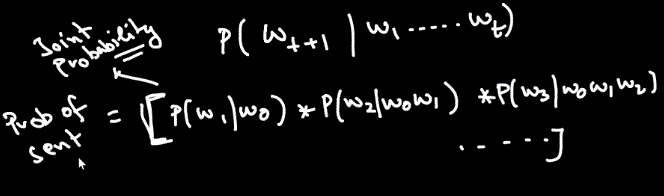


https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

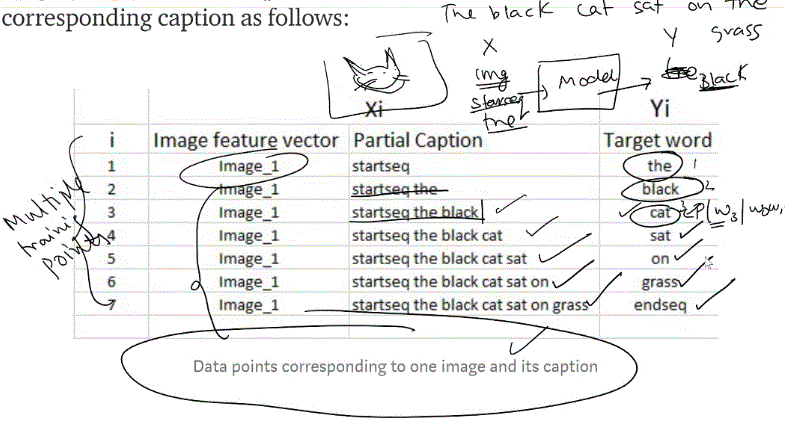

### Data Loader

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [ ]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [ ]:
embedding_index['apple'] # embedding for apple

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

### Model Architecture
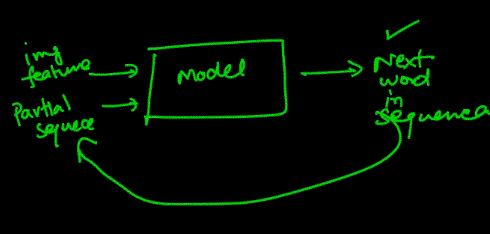

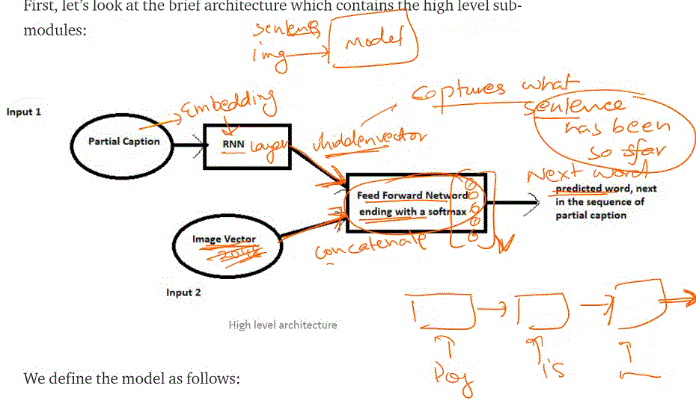

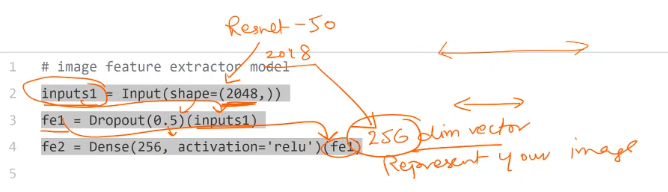

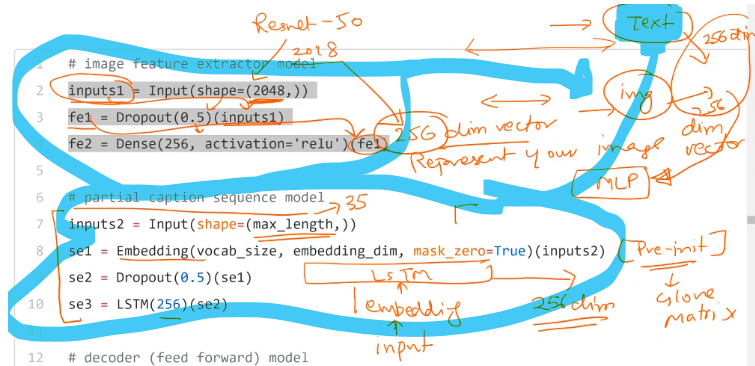

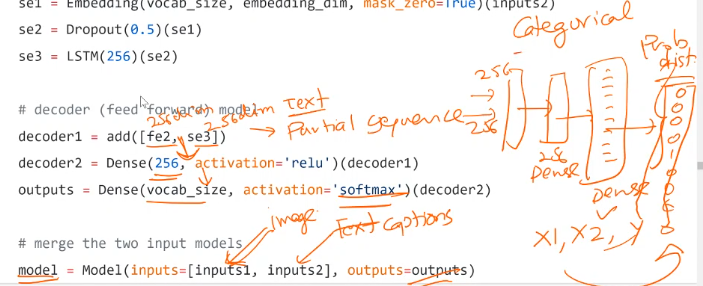

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

In [ ]:
# Embedding Layer most important
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

- categorical_crossentropy is used with large no. of classes

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [105]:
# model training 
epochs = 20
batch_size = 3
steps = len(train_descriptions)//64


In [ ]:
import pydot
import graphviz
tf.keras.utils.plot_model(model, show_shapes=True)

Considering batch size to be 3 ,
at each step we would be training our for 1 batch , means 3 images with there respective captions . So , the number of pics per batch will be equal to batch_Size.
hence, number of pics per batch is 3.

and steps = 1000 //3 = 33 ( assuming your len( train_descriptions ) = 1000 )

In [106]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [134]:
model = load_model('./model_weights/model_9.h5')

## FINAL PREDICTIONS

In [141]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        final_caption = set()
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() 
        word = idx_to_word[ypred]
        in_text = ' ' + word
        final_caption.add(in_text)
        
        print(in_text)
        
        if word == "endseq":
            break
    
#         final_caption = in_text.split()[1:-1]
        st = ' '.join(final_caption)
        final_caption.clear()
    
    return st

In [43]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("dataset/images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [ ]:
len(encoding_test)